<bold>This is it. You have seen how to define neural networks, compute loss and make updates to the weights of the network.

Now you might be thinking,

What about data?
Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a torch.*Tensor.

For images, packages such as Pillow, OpenCV are useful
For audio, packages such as scipy and librosa
For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful
Specifically for vision, we have created a package called torchvision, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., torchvision.datasets and torch.utils.data.DataLoader.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

cifar10
cifar10

Training an image classifier
We will do the following steps in order:

Load and normalizing the CIFAR10 training and test datasets using torchvision
Define a Convolutional Neural Network
Define a loss function
Train the network on the training data
Test the network on the test data</bold>

### Loading and normalization CIFAR10

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5,.5,.5), (.5,.5,.5))])
train_set = torchvision.datasets.CIFAR10(root="./data/", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
test_set = torchvision.datasets.CIFAR10(root="./data/",train=False,download=True, transform=transform)
testloader =torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


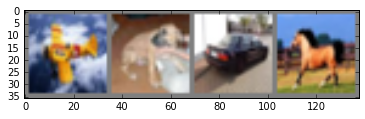

plane   dog   car horse


In [4]:
# train
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#show one image
def imshow(img):
    img = img/2.0 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
#get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
#show images
imshow(torchvision.utils.make_grid(images))
#print labels
print(" ".join("%5s" % classes[labels[j]] for j in range(4)))

In [5]:
labels

tensor([0, 5, 1, 7])

In [6]:
# Define a CNN
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
#loss and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=.001, momentum=.9)

In [9]:
#train
for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        #get inputs
        inputs, labels = data
        #zero the gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss : %.3f' % (epoch + 1, i + 1, running_loss / 2000.0))
            running_loss = 0.0
print("finished trainning!")

[1,  2000] loss : 1.173
[1,  4000] loss : 1.138
[1,  6000] loss : 1.133
[1,  8000] loss : 1.135
[1, 10000] loss : 1.108
[1, 12000] loss : 1.133
[2,  2000] loss : 1.032
[2,  4000] loss : 1.037
[2,  6000] loss : 1.042
[2,  8000] loss : 1.062
[2, 10000] loss : 1.043
[2, 12000] loss : 1.048
finished trainning!


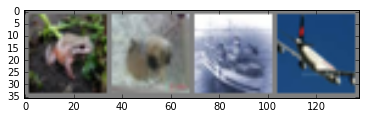

('GroundTruth: ', ' frog   dog  ship plane')


In [11]:
#test
dataiter = iter(testloader)
images, labels = dataiter.next()
#print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join("%5s" % classes[labels[j]] for j in range(4)))

In [13]:
outputs = net(images)
#The outputs are energies for the 10 classes. The higher the energy for a class,
#the more the network thinks that the image is of the particular class. 
#So, let’s get the index of the highest energy:
_, predicted = torch.max(outputs, 1)
print("predicted: ", " ".join("%5s" % classes[predicted[j]] for j in range(4)))

('predicted: ', ' frog  bird  ship  ship')


In [14]:
outputs

tensor([[-0.6499, -0.6212,  0.0587,  0.2918,  0.9543, -0.3298,  3.9934, -2.4949,
         -2.8642,  0.8535],
        [ 1.4980, -3.6651,  4.1652,  0.9199,  1.9160,  0.5599,  1.7204, -1.9958,
         -1.8800, -3.0827],
        [ 1.4153,  0.8391,  1.0036, -0.9781, -0.9852, -2.6805,  0.1946, -2.9926,
          3.4571,  0.2454],
        [ 3.2615,  0.5142,  3.9484, -2.5473,  0.8241, -4.3899,  0.2898, -5.9227,
          4.3081, -1.8540]], grad_fn=<AddmmBackward>)

In [16]:
# on whole test dateset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("accuracy of the net work on the 10000 test images: %d %%" % (100.0 * correct / total))

accuracy of the net work on the 10000 test images: 59 %


In [21]:
# on all the classes
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 77 %
Accuracy of  bird : 52 %
Accuracy of   cat : 37 %
Accuracy of  deer : 36 %
Accuracy of   dog : 50 %
Accuracy of  frog : 81 %
Accuracy of horse : 56 %
Accuracy of  ship : 69 %
Accuracy of truck : 70 %


### train on a GPU

In [22]:
# like transfer tensor onto the GPU, transfer the neural net onto GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [29]:
net = net.cuda()

In [30]:
# remember to send all the inputs and targets at every step to GPU too:
inputs, labels = inputs.to(device), labels.to(device)

In [35]:
optimizer = optim.SGD(net.parameters(), lr=.001, momentum=.9)

In [36]:
#train
for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        #get inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        #zero the gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss : %.3f' % (epoch + 1, i + 1, running_loss / 2000.0))
            running_loss = 0.0
print("finished trainning!")

[1,  2000] loss : 0.964
[1,  4000] loss : 0.972
[1,  6000] loss : 0.981
[1,  8000] loss : 0.983
[1, 10000] loss : 0.986
[1, 12000] loss : 0.980
[2,  2000] loss : 0.879
[2,  4000] loss : 0.918
[2,  6000] loss : 0.916
[2,  8000] loss : 0.937
[2, 10000] loss : 0.921
[2, 12000] loss : 0.936
finished trainning!
